In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [5]:
import random
import os
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1234)
    tf.random.set_seed(1234)
    np.random.seed(1234)
    random.seed(1234)

In [6]:
#read csv, print 5 rows
klangapi = pd.read_csv('klangapiCleanedDailyMean.csv')
klangapi=klangapi.replace(0.0000,np.NaN)
# #klangapi[(klangapi == 0.0).any(axis=1)]
klangapi.interpolate(method ='linear', limit_direction ='forward', inplace=True)

#change data type "date" from object to actual date for easy analysis
klangapi['date']=pd.to_datetime(klangapi['date'])
#set index to date
klangapi.set_index('date',inplace=True)
klangapi.drop(['nox'], axis=1, inplace=True)

klangapi.head(10)

,wind_speed,wind_direction,temperature,relative_humidity,no,so2,no2,o3,co,pm10
date,,,,,,,,,,
2002-10-01,4.2125,170.1875,27.3729,72.7500,0.0409,0.0097,0.0342,0.0241,2.3044,108.6875
2002-10-02,4.9542,111.8750,27.4375,72.8333,0.0247,0.0077,0.0354,0.0203,1.7673,108.3333
2002-10-03,5.0542,123.2083,26.8250,77.0833,0.0261,0.0119,0.0349,0.0191,1.7481,99.9583
2002-10-04,3.6958,134.3750,26.4875,79.2500,0.0506,0.0121,0.0366,0.0191,2.4892,116.6250
2002-10-05,4.4708,188.9167,26.4750,80.3333,0.0305,0.0072,0.0234,0.0165,1.7731,94.9583
2002-10-06,4.3167,142.6667,26.0750,82.4167,0.0229,0.0074,0.0242,0.0202,1.5633,83.7083
2002-10-07,3.9583,177.5000,25.4000,84.0625,0.0487,0.0089,0.0250,0.0120,1.9575,75.5625
2002-10-08,5.4917,137.3750,27.5083,76.7500,0.0105,0.0071,0.0154,0.0188,0.9352,53.6458
2002-10-09,5.1500,164.2083,27.8250,74.8333,0.0149,0.0090,0.0177,0.0311,1.0512,70.3958


In [7]:
trainTest=klangapi.loc['2002-01':'2019-12-31'].copy() #2002-2017/3/31
verifyDeploy=klangapi.loc['2020-01-01':'2020-12-31'].copy() #2018
jumlahTrainNTest=trainTest.shape[0]        
jumlahVerification=verifyDeploy.shape[0]
print(jumlahTrainNTest,jumlahVerification,jumlahTrainNTest+jumlahVerification)

6039 366 6405


In [8]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# scaler = StandardScaler()
# scaler = scaler.fit(klangapi)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(klangapi)
trainTestScaled = scaler.transform(trainTest)
verifyDeployScaled = scaler.transform(verifyDeploy)
trainTestScaled.shape,verifyDeployScaled.shape

((6039, 10), (366, 10))

In [9]:
##splitting dataset into train and test split
training_size=int(len(trainTestScaled)*0.85)
test_size=len(trainTestScaled)-training_size
train,test=trainTestScaled[0:training_size,:],trainTestScaled[training_size:len(trainTestScaled),:]
train.shape,test.shape

((5133, 10), (906, 10))

## END OF SEGMENT

In [10]:
# references target features
# 10 = pm10
# 9 = co
# 8 = o3
# 7 = no2
# 6 = so2
# 5 = no
# 4 = nox

In [11]:
# function to organize data in correct forms so that the data can be fitted to the model
# data, number of past days, number of features, target pollutants to be predicted
def to_sequences(dataset, n_past, no_features, target_features):
    # n_past: Number of past days we want to use to predict the future.
    X = []
    y = []
    n_future = 1  # Number of days we want to look into the future based on the past days.
    for i in range(n_past, len(dataset) - n_future +1):
        X.append(dataset[i - n_past:i, 0:no_features])
        y.append(dataset[i + n_future - 1:i + n_future, target_features]) 
    return np.array(X), np.array(y)



# function to build LSTM model
def modelling(train, test, past_days, target_features):
    reset_random_seeds()
    
    #structuring the shape of training data into (number of rows, number of past days, number of features)
    #structuring the shape of target features into (number of rows, number of feature)
    trainX, trainY = to_sequences(train, past_days, klangapi.shape[1],target_features)
    testX, testY = to_sequences(test, past_days, klangapi.shape[1],target_features)
    verifyX, verifyY = to_sequences(verifyDeployScaled, past_days, klangapi.shape[1],target_features)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    print('testX shape == {}.'.format(testX.shape))
    print('testY shape == {}.'.format(testY.shape))
    print('verifyX shape == {}.'.format(verifyX.shape))
    print('verifyY shape == {}.'.format(verifyY.shape))
    print('\n')
    
    #modelling
    model = Sequential()
    model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
#     model.add(LSTM(448, activation='tanh', return_sequences=False))
#     model.add(Dense(64))
    # model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.summary()
    history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_split=0.2, verbose=1)
    
    print('Loss wrt epoch : ')
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show() 
    
    prediction = model.predict(testX)
    prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,target_features]
    actualY = np.repeat(testY, klangapi.shape[1], axis=-1)
    actualY = scaler.inverse_transform(actualY)[:,target_features]
    print('\n')
    
    print('Model performance on training data : ')
    rmse, mae, mape = performance_measure(actualY,y_pred_future)
    print('RMSE : {}.'.format(rmse))
    print('MAE : {}.'.format(mae))
    print('MAPE : {}.'.format(mape))
    print('How model predict training data : ')
    train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})     
    plt.plot(train_results['Actuals'][0:])
    plt.plot(train_results['Train Predictions'][0:])
    plt.show()

    prediction = model.predict(verifyX)
    prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
    y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,target_features]
    verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
    verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,target_features]
    print('Model performance on verification data : ')
    rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
    print('RMSE : {}.'.format(rmse))
    print('MAE : {}.'.format(mae))
    print('MAPE : {}.'.format(mape))
    test_results = pd.DataFrame(data = {'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
    print('How model predict verification data : ')
    plt.plot(test_results['Actuals'][:])
    plt.plot(test_results['Train Predictions'][:])
    plt.show()
    
    # function to retrieve performance of the model
def performance_measure(actual,pred) :
    rmse=math.sqrt(mean_squared_error(actual,pred, squared=False))
    mae=mean_absolute_error(actual, pred)
    mape=mean_absolute_percentage_error(actual, pred)*100
    return rmse,mae,mape


Modelling for : no.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5504      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0147 - val_loss: 0.0065
Epoch 2/20
513/513 [==============================] - 0s 657us/step - loss: 0.0123 - val_los

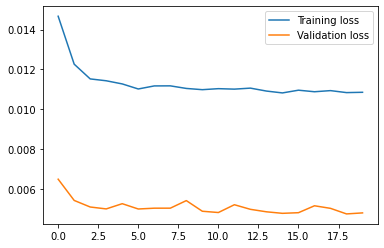



Model performance on training data : 
RMSE : 0.09068021219049857.
MAE : 0.007076058835895583.
MAPE : 146.65070392044268.
How model predict training data : 


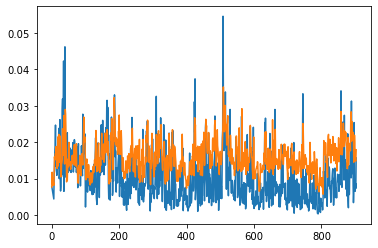

Model performance on verification data : 
RMSE : 0.09410390003026198.
MAE : 0.0081242522282137.
MAPE : 178.3849893080528.
How model predict verification data : 


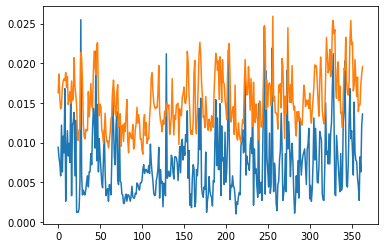





Modelling for : so2.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0034
Epoch 2/20
513/513 [==============================] - 0s 628us/step - loss: 0.0065 - 

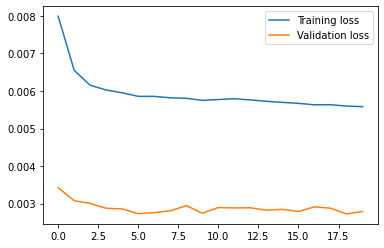



Model performance on training data : 
RMSE : 0.040200379397144846.
MAE : 0.0014608207672199777.
MAPE : 116.99089152521492.
How model predict training data : 


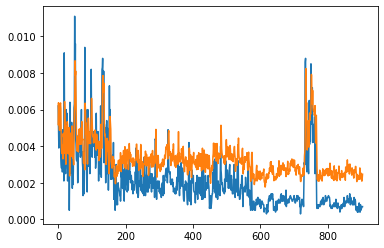

Model performance on verification data : 
RMSE : 0.041286844768061756.
MAE : 0.0016261889676046609.
MAPE : 159.3935497600247.
How model predict verification data : 


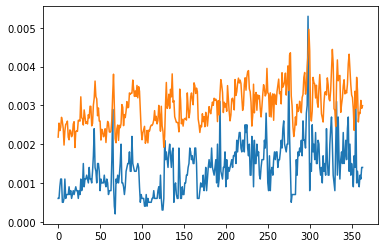





Modelling for : no2.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0223 - val_loss: 0.0129
Epoch 2/20
513/513 [==============================] - 0s 645us/step - loss: 0.0164 - 

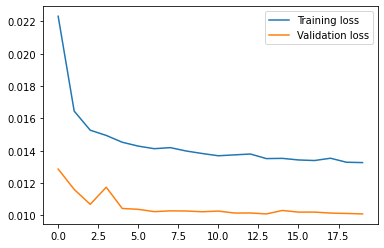



Model performance on training data : 
RMSE : 0.06925472852300671.
MAE : 0.0039567147345504665.
MAPE : 27.430155202901375.
How model predict training data : 


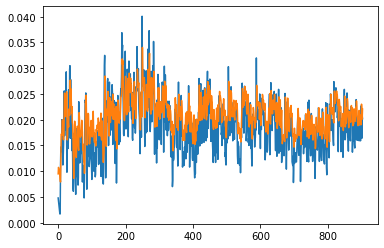

Model performance on verification data : 
RMSE : 0.07303071850619035.
MAE : 0.004499735779675482.
MAPE : 40.22241475788484.
How model predict verification data : 


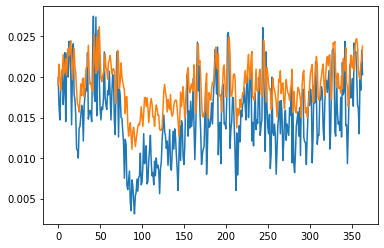





Modelling for : o3.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0151 - val_loss: 0.0126
Epoch 2/20
513/513 [==============================] - 0s 636us/step - loss: 0.0117 - v

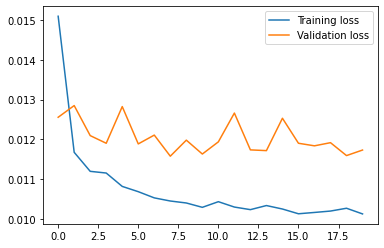



Model performance on training data : 
RMSE : 0.06934808433691689.
MAE : 0.0038272841706229123.
MAPE : 34.929006572271966.
How model predict training data : 


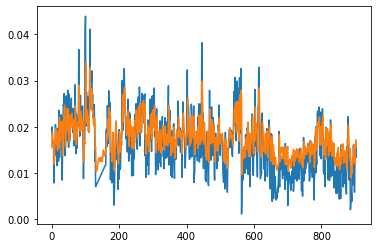

Model performance on verification data : 
RMSE : 0.06592513219393004.
MAE : 0.0034069176727476026.
MAPE : 27.38651191718608.
How model predict verification data : 


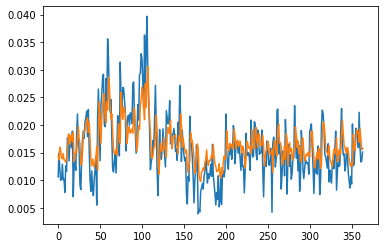





Modelling for : co.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 2/20
513/513 [==============================] - 0s 624us/step - loss: 0.0040 - v

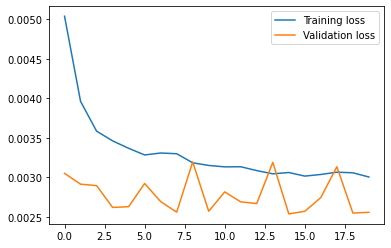



Model performance on training data : 
RMSE : 0.44684861107663715.
MAE : 0.1604901477388576.
MAPE : 23.478979983158265.
How model predict training data : 


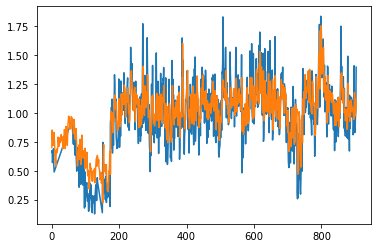

Model performance on verification data : 
RMSE : 0.4309735760712416.
MAE : 0.1514565544317057.
MAPE : 22.178373530752555.
How model predict verification data : 


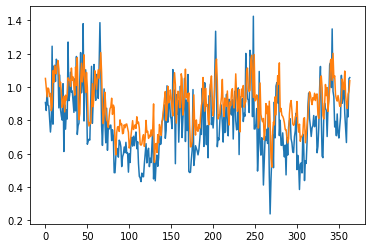





Modelling for : pm10.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 2/20
513/513 [==============================] - 0s 684us/step - loss: 0.0018 -

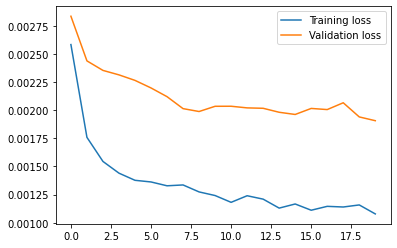



Model performance on training data : 
RMSE : 4.2663980829094115.
MAE : 14.587264438406345.
MAPE : 43.151769722541985.
How model predict training data : 


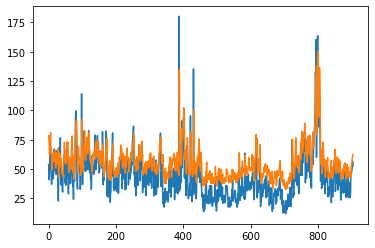

Model performance on verification data : 
RMSE : 4.052294963654558.
MAE : 14.540364220705136.
MAPE : 50.995815537586296.
How model predict verification data : 


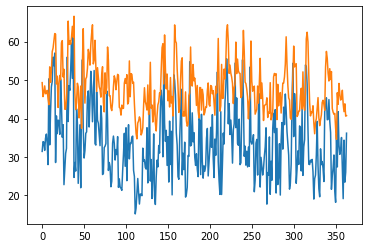

In [12]:
for i in range(4,len(klangapi.columns)):
    print('Modelling for : {}.'.format(klangapi.columns[i]))
    modelling(train,test, 2, i)
    print('\n')
    print('\n')

modelling(train,test,3,5)